In [11]:
# August 25 2017
# This file is for experiments with student2 4 skills and training trajectory length 5
# to check different architectures and whether they can learn good models
# This uses student2a where transitions happen after observations

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
import six
import pickle
from matplotlib.pyplot import *

def ixs2ranks(ixs):
    ranks = np.zeros(ixs.shape,dtype=np.int)
    for r,i in enumerate(ixs):
        ranks[i] = r
    return ranks

def extract_ensemble_data(outdata):
    split_num = len(outdata)
    six.print_(len(outdata[0]))
    six.print_(len(outdata[0][0]))
    six.print_(len(outdata[0][0][0]))
    
    sq = np.mean([ [ trial[0][1][1]  for trial in split] for split in outdata ], axis=1)
    sim_sq = np.mean([ [ trial[0][1][3]  for trial in split] for split in outdata ], axis=1)
    
    return sq, sim_sq

def extract_last_step_error(multistep):
    random_errors = np.array([model_output[0][0][-1] for model_output in multistep])
    expert_errors = np.array([model_output[0][1][-1] for model_output in multistep])
    return random_errors, expert_errors

def average_error_per_step(multistep):
    # compute the average over all models of their errors per step
    num_models = len(multistep)
    random_errors = np.mean([model_output[0][0] for model_output in multistep], axis=0)
    expert_errors = np.mean([model_output[0][1] for model_output in multistep], axis=0)
    return random_errors, expert_errors

def graph_average_ms(ms):
    ms_random, ms_expert = average_error_per_step(ms)
    figure()
    title('Average Multistep Error Per Step')
    xlabel('Step')
    ylabel('MSE')
    xs = np.arange(ms_random.shape[0])
    plot(xs, ms_random,label='random')
    plot(xs, ms_expert,label='expert')
    legend()

def graph_trainauc_score(vloss, scores):
    figure()
    xs = np.sum(vloss,axis=1)
    ys = scores
    title('Training Loss AUC versus Actual Performance')
    xlabel('Training Loss AUC')
    ylabel('Posttest Score')
    plot(xs,ys,'.')
    ylim(0,1)

def graph_trainauc_qval(vloss, qval):
    figure()
    xs = np.sum(vloss,axis=1)
    ys = qval
    title('Training Loss AUC versus Own Qvalue')
    xlabel('Training Loss AUC')
    ylabel('Qvalue')
    plot(xs,ys,'.')

def graph_qval_score(qval, scores):
    figure()
    xs = qval
    ys = scores
    title('Own Qval versus Actual Performance')
    xlabel('Qvalue')
    ylabel('Posttest Score')
    plot(xs,ys,'.')

def graph_ms_score(ms, scores, policy):
    figure()
    xs = ms
    ys = scores
    title('Last Step Multistep Error versus Actual Performance for {} Policy'.format(policy))
    xlabel('Last Step Multistep MSE')
    ylabel('Posttest Score')
    plot(xs,ys,'.')

def graph_ensemble(fsen_sq, fsen_sim_sq):
    figure()
    title('Ensemble Size versus Actual Performance')
    xs = np.array(list(six.moves.range(len(fsen_sq))))*5+5
    ys = fsen_sim_sq
    xlabel('# of models in ensemble')
    ylabel('Posttest Score')
    plot(xs, ys, '.')
    ylim(-0.1,1.1)
    if False:
        figure()
        title('Ensemble Size versus Own Qvalue')
        xs = np.array(list(six.moves.range(len(fsen_sq))))*5+5
        ys = fsen_sq
        xlabel('# of models in ensemble')
        ylabel('Qvalue')
        plot(xs, ys, '.')
        ylim(-0.1,1.1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Learning Rate 0.0005 Stability

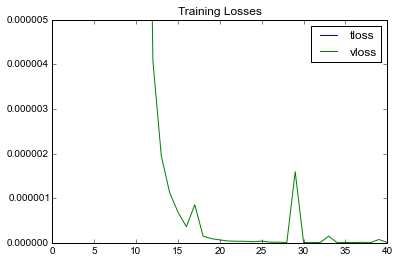

In [7]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.000005)
legend()
# looks like after 20 is enough. Use 25.

# Learning Rate 0.0005 Noise 0.05 Stability

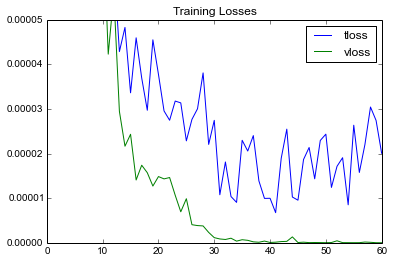

In [8]:
data11 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.00005)
legend()
# looks like around 50

# Learning Rate 0.0005 Output Dropout 0.5 Stability

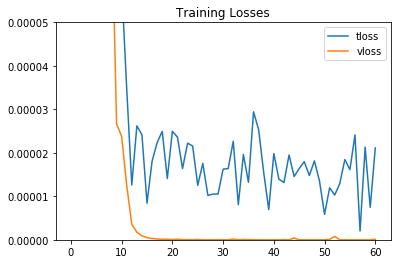

In [2]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.00005)
legend()
# looks like 25 is fine

# Learning Rate 0.0005 Output Dropout 0.5 Noise 0.05 Stability

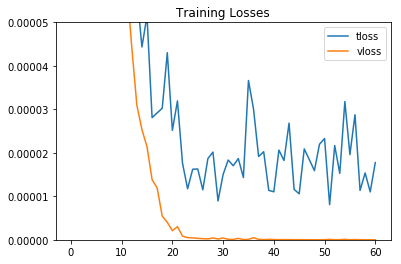

In [3]:
data11 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.00005)
legend()
# looks like 45 again is fine

# Debug Memoize on Stability Runs

In [6]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mem-runA0-epoch40.npz')
six.print_(data11.files)
mem_arrays = data11['mem_arrays']
six.print_(mem_arrays[0])
six.print_(mem_arrays[1])
six.print_(mem_arrays[5][1000])

['mem_arrays']
[[ 0.  0.  0.  0.]]
[[  9.99760926e-01   3.76824639e-03   8.07295844e-04   9.57022654e-04]
 [  9.99999642e-01   1.92387219e-04   1.35941254e-05   2.43485943e-06]
 [  9.99998569e-01   2.81491225e-06   1.97608519e-04   1.10886810e-06]
 [  9.99971271e-01   1.81344876e-05   1.97847603e-05   5.24370116e-05]
 [  9.99985337e-01   1.15873900e-05   2.18772057e-05   1.53569781e-05]
 [  9.99988198e-01   8.85017812e-02   7.98502413e-04   1.37441570e-03]
 [  9.99203026e-01   2.60969537e-04   4.24301326e-02   1.45776814e-03]
 [  9.99477923e-01   7.42685515e-04   2.93014711e-03   2.23981193e-03]]
[  9.99999881e-01   9.99945760e-01   6.82999162e-05   2.55893869e-03]


# No Noise

40
1
2
vloss shape (50, 26)


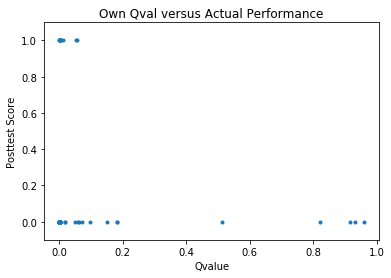

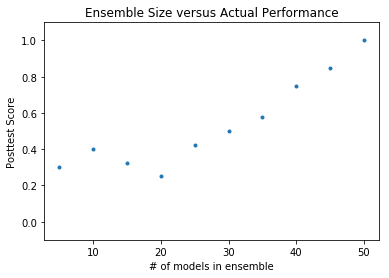

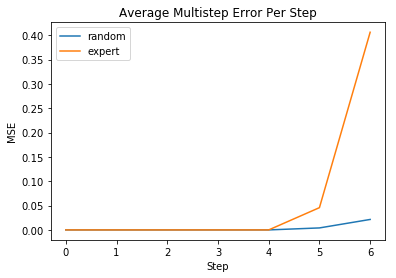

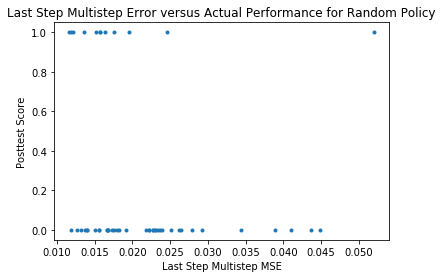

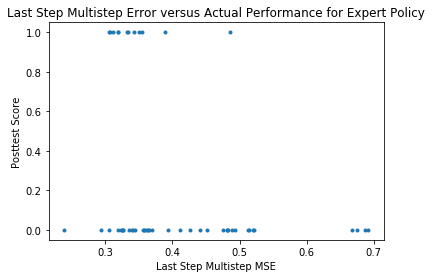

In [12]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runB.npz')
data21 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mcts-rtype2-rollouts10000-trajectories8-real1-runB.npz')
data31 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mcts-rtype2-rollouts10000-trajectories8-real0-runB.npz')

with open('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearch-runB-horizon6.pickle','rb') as f:
    fsdata = pickle.load(f)

with open('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearchensemble-runB-horizon6-n40.pickle','rb') as f:
    fsensemble = pickle.load(f)

with open('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/multistep-runB-horizon6-n10000.pickle','rb') as f:
    multistep = pickle.load(f)

fs_sq = np.array([d[0][1] for d in fsdata])
fs_sim_sq = np.array([d[0][3] for d in fsdata])

fsen_sq, fsen_sim_sq = extract_ensemble_data(fsensemble)

vloss = np.vstack((data11['vloss'],))
vloss_auc = np.sum(vloss,axis=1)
vloss_last = np.mean(vloss[:,-2:],axis=1)

tloss = np.vstack((data11['tloss'],))
tloss_auc = np.sum(tloss,axis=1)
tloss_last = np.mean(tloss[:,-2:],axis=1)

#scores = np.vstack((data21['scores'],))[:,0]
#realqvals = np.vstack((data21['qvals'],))[:,0]
#selfqvals = np.vstack((data31['qvals'],))[:,0]

# ixs sorted by various things
#sorted_by_score = np.flipud(np.argsort(scores))
#ranked_by_score = ixs2ranks(sorted_by_score)

sorted_by_fs_sim_sq = np.flipud(np.argsort(fs_sim_sq))
ranked_by_fs_sim_sq = ixs2ranks(sorted_by_fs_sim_sq)

sorted_by_fs_sq = np.flipud(np.argsort(fs_sq))
ranked_by_fs_sq = ixs2ranks(sorted_by_fs_sq)

sorted_by_vloss = np.argsort(vloss_auc)
ranked_by_vloss = ixs2ranks(sorted_by_vloss)

#sorted_by_qval = np.flipud(np.argsort(selfqvals))
#ranked_by_qval = ixs2ranks(sorted_by_qval)

six.print_('vloss shape {}'.format(vloss.shape))

num_models = vloss_auc.shape[0]

# 12/50 good policy-models

#graph_trainauc_score(vloss, fs_sim_sq)
#ylim(-0.1,1.1)


graph_qval_score(fs_sq, fs_sim_sq)
ylim(-0.1,1.1)

graph_ensemble(fsen_sq, fsen_sim_sq)

# multistep stuff
ms_random, ms_expert = extract_last_step_error(multistep)
graph_average_ms(multistep)

graph_ms_score(ms_random, fs_sim_sq, 'Random')
graph_ms_score(ms_expert, fs_sim_sq, 'Expert')

In [21]:
for i in six.moves.range(num_models):
    ix = sorted_by_fs_sq[i]
    six.print_('{:2d} | fs sim sq {:.1f} {:2d}th | vloss auc {:.5f} {:2d}th | fs sq {:.4f} {:2d}th'.format(
        ix, fs_sim_sq[ix], ranked_by_fs_sim_sq[ix], vloss_auc[ix], ranked_by_vloss[ix], fs_sq[ix], ranked_by_fs_sq[ix]))

48 | fs sim sq 0.0 40th | vloss auc 0.04276 41th | fs sq 0.6436  0th
27 | fs sim sq 1.0  3th | vloss auc 0.03269 18th | fs sq 0.4515  1th
23 | fs sim sq 1.0  2th | vloss auc 0.03911 32th | fs sq 0.2222  2th
39 | fs sim sq 0.0 38th | vloss auc 0.03171 15th | fs sq 0.2149  3th
38 | fs sim sq 1.0  7th | vloss auc 0.04138 40th | fs sq 0.0738  4th
41 | fs sim sq 1.0  4th | vloss auc 0.03703 27th | fs sq 0.0609  5th
14 | fs sim sq 0.0 14th | vloss auc 0.03878 30th | fs sq 0.0238  6th
22 | fs sim sq 0.0 29th | vloss auc 0.02849  2th | fs sq 0.0167  7th
12 | fs sim sq 1.0  1th | vloss auc 0.04350 43th | fs sq 0.0143  8th
11 | fs sim sq 0.0 17th | vloss auc 0.04484 44th | fs sq 0.0135  9th
 5 | fs sim sq 0.0 22th | vloss auc 0.02810  1th | fs sq 0.0021 10th
32 | fs sim sq 1.0  9th | vloss auc 0.02874  5th | fs sq 0.0014 11th
21 | fs sim sq 0.0 18th | vloss auc 0.03332 19th | fs sq 0.0013 12th
47 | fs sim sq 0.0 31th | vloss auc 0.04067 39th | fs sq 0.0008 13th
24 | fs sim sq 0.0 28th | vloss au

# Noise 0.05

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
40
1
2
[ 0.75   0.75   0.925  0.8    0.825  0.85   0.85   0.925  0.95   1.   ]
[ 0.03873459  0.03698538  0.03162431  0.031827    0.0305638   0.0278018
  0.02717527  0.02645574  0.02730826  0.02744734]
vloss shape (50, 46)
[ 0.42196651  0.33511917  0.41337579  0.52380189  0.53696242  0.50203394
  0.35479847  0.62253892  0.43572341  0.42771214  0.339395    0.35531035
  0.47902498  0.34382257  0.29848595  0.45642496  0.57234222  0.56349942
  0.50162925  0.42734207  0.45865837  0.52769739  0.48648419  0.33340937
  0.44726853  0.40476237  0.48475804  0.27559961  0.37898429  0.59985815
  0.29809997  0.66162298  0.32233865  0.63303961  0.51154221  0.29894111
  0.39651434  0.52473431  0.42365011  0.49543286  0.53816393  0.34017511
  0.36658258  0.5401004   0.41714008  0.44151442  0.32739749  0

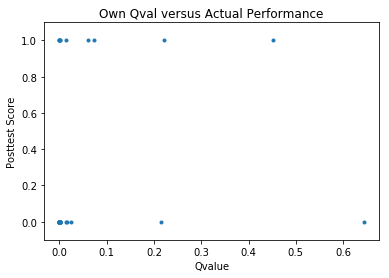

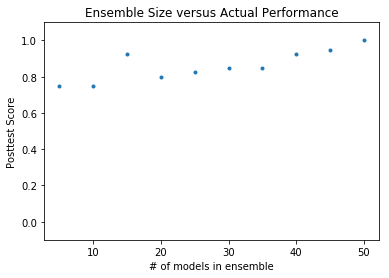

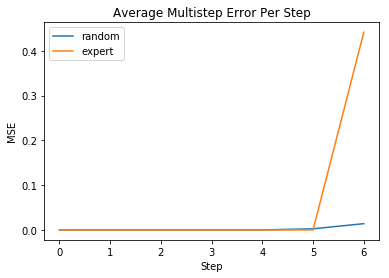

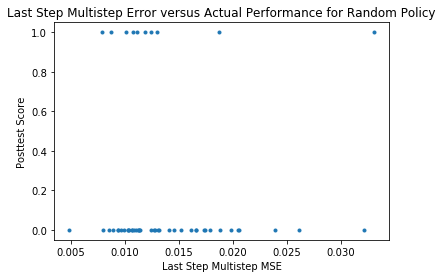

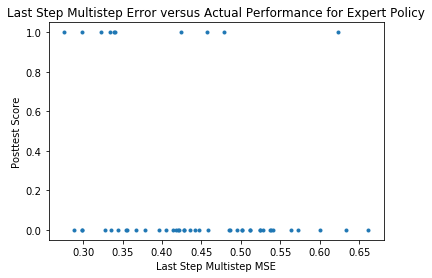

In [15]:
data11 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runB.npz')
data21 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mcts-rtype2-rollouts10000-trajectories8-real1-runB.npz')
data31 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mcts-rtype2-rollouts10000-trajectories8-real0-runB.npz')

with open('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearch-runB-horizon6.pickle','rb') as f:
    fsdata = pickle.load(f)
with open('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearchensemble-runB-horizon6-n40.pickle','rb') as f:
    fsensemble = pickle.load(f)
with open('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/multistep-runB-horizon6-n10000.pickle','rb') as f:
    multistep = pickle.load(f)
fs_sq = np.array([d[0][1] for d in fsdata])
fs_sim_sq = np.array([d[0][3] for d in fsdata])
six.print_(fs_sim_sq)

fsen_sq, fsen_sim_sq = extract_ensemble_data(fsensemble)
six.print_(fsen_sim_sq)
six.print_(fsen_sq)

vloss = np.vstack((data11['vloss'],))
vloss_auc = np.sum(vloss,axis=1)
vloss_last = np.mean(vloss[:,-2:],axis=1)

tloss = np.vstack((data11['tloss'],))
tloss_auc = np.sum(tloss,axis=1)
tloss_last = np.mean(tloss[:,-2:],axis=1)

#scores = np.vstack((data21['scores'],))[:,0]
#realqvals = np.vstack((data21['qvals'],))[:,0]
#selfqvals = np.vstack((data31['qvals'],))[:,0]

# ixs sorted by various things
#sorted_by_score = np.flipud(np.argsort(scores))
#ranked_by_score = ixs2ranks(sorted_by_score)

sorted_by_fs_sim_sq = np.flipud(np.argsort(fs_sim_sq))
ranked_by_fs_sim_sq = ixs2ranks(sorted_by_fs_sim_sq)

sorted_by_fs_sq = np.flipud(np.argsort(fs_sq))
ranked_by_fs_sq = ixs2ranks(sorted_by_fs_sq)

sorted_by_vloss = np.argsort(vloss_auc)
ranked_by_vloss = ixs2ranks(sorted_by_vloss)

#sorted_by_qval = np.flipud(np.argsort(selfqvals))
#ranked_by_qval = ixs2ranks(sorted_by_qval)

six.print_('vloss shape {}'.format(vloss.shape))

num_models = vloss_auc.shape[0]

#graph_trainauc_score(vloss, fs_sim_sq)
#ylim(-0.1,1.1)
# 10/50 good policy-models


graph_qval_score(fs_sq, fs_sim_sq)
ylim(-0.1,1.1)

#graph_qval_score(fsen_sq, fsen_sim_sq)
#ylim(-0.1,1.1)

graph_ensemble(fsen_sq, fsen_sim_sq)

# multistep stuff
ms_random, ms_expert = extract_last_step_error(multistep)
graph_average_ms(multistep)

graph_ms_score(ms_random, fs_sim_sq, 'Random')
graph_ms_score(ms_expert, fs_sim_sq, 'Expert')

In [22]:
for i in six.moves.range(num_models):
    ix = sorted_by_fs_sq[i]
    six.print_('{:2d} | fs sim sq {:.1f} {:2d}th | vloss auc {:.5f} {:2d}th | fs sq {:.4f} {:2d}th'.format(
        ix, fs_sim_sq[ix], ranked_by_fs_sim_sq[ix], vloss_auc[ix], ranked_by_vloss[ix], fs_sq[ix], ranked_by_fs_sq[ix]))

48 | fs sim sq 0.0 40th | vloss auc 0.04276 41th | fs sq 0.6436  0th
27 | fs sim sq 1.0  3th | vloss auc 0.03269 18th | fs sq 0.4515  1th
23 | fs sim sq 1.0  2th | vloss auc 0.03911 32th | fs sq 0.2222  2th
39 | fs sim sq 0.0 38th | vloss auc 0.03171 15th | fs sq 0.2149  3th
38 | fs sim sq 1.0  7th | vloss auc 0.04138 40th | fs sq 0.0738  4th
41 | fs sim sq 1.0  4th | vloss auc 0.03703 27th | fs sq 0.0609  5th
14 | fs sim sq 0.0 14th | vloss auc 0.03878 30th | fs sq 0.0238  6th
22 | fs sim sq 0.0 29th | vloss auc 0.02849  2th | fs sq 0.0167  7th
12 | fs sim sq 1.0  1th | vloss auc 0.04350 43th | fs sq 0.0143  8th
11 | fs sim sq 0.0 17th | vloss auc 0.04484 44th | fs sq 0.0135  9th
 5 | fs sim sq 0.0 22th | vloss auc 0.02810  1th | fs sq 0.0021 10th
32 | fs sim sq 1.0  9th | vloss auc 0.02874  5th | fs sq 0.0014 11th
21 | fs sim sq 0.0 18th | vloss auc 0.03332 19th | fs sq 0.0013 12th
47 | fs sim sq 0.0 31th | vloss auc 0.04067 39th | fs sq 0.0008 13th
24 | fs sim sq 0.0 28th | vloss au

# Output Dropout 0.5

[ 0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.
  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.]
40
1
2
[ 0.5    0.625  0.775  0.775  0.925  1.     0.95   0.95   1.     1.   ]
[ 0.1208843   0.12495127  0.1114807   0.10827274  0.12547279  0.11291362
  0.11422925  0.11723958  0.10940342  0.11215429]
vloss shape (50, 26)


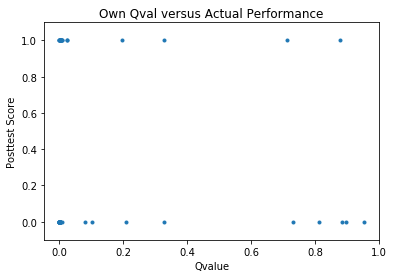

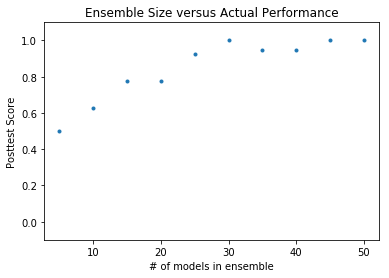

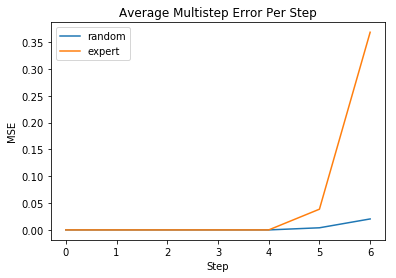

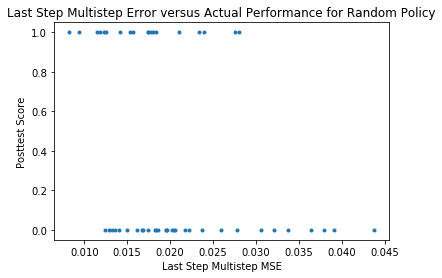

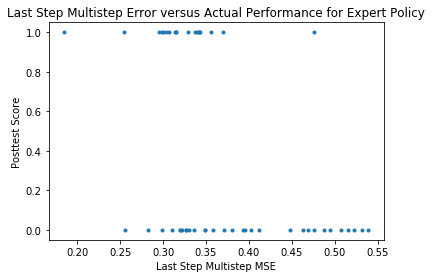

In [17]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runB.npz')

with open('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearch-runB-horizon6.pickle','rb') as f:
    fsdata = pickle.load(f)

with open('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearchensemble-runB-horizon6-n40.pickle','rb') as f:
    fsensemble = pickle.load(f)

with open('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/multistep-runB-horizon6-n10000.pickle','rb') as f:
    multistep = pickle.load(f)
    
fs_sq = np.array([d[0][1] for d in fsdata])
fs_sim_sq = np.array([d[0][3] for d in fsdata])
six.print_(fs_sim_sq)

fsen_sq, fsen_sim_sq = extract_ensemble_data(fsensemble)
six.print_(fsen_sim_sq)
six.print_(fsen_sq)

vloss = np.vstack((data11['vloss'],))
vloss_auc = np.sum(vloss,axis=1)
vloss_last = np.mean(vloss[:,-2:],axis=1)

tloss = np.vstack((data11['tloss'],))
tloss_auc = np.sum(tloss,axis=1)
tloss_last = np.mean(tloss[:,-2:],axis=1)

sorted_by_fs_sim_sq = np.flipud(np.argsort(fs_sim_sq))
ranked_by_fs_sim_sq = ixs2ranks(sorted_by_fs_sim_sq)

sorted_by_fs_sq = np.flipud(np.argsort(fs_sq))
ranked_by_fs_sq = ixs2ranks(sorted_by_fs_sq)

sorted_by_vloss = np.argsort(vloss_auc)
ranked_by_vloss = ixs2ranks(sorted_by_vloss)

six.print_('vloss shape {}'.format(vloss.shape))

num_models = vloss_auc.shape[0]

#graph_trainauc_score(vloss, fs_sim_sq)
#ylim(-0.1,1.1)
# 19/50 good policy-models


graph_qval_score(fs_sq, fs_sim_sq)
ylim(-0.1,1.1)

graph_ensemble(fsen_sq, fsen_sim_sq)

# multistep stuff
ms_random, ms_expert = extract_last_step_error(multistep)
graph_average_ms(multistep)

graph_ms_score(ms_random, fs_sim_sq, 'Random')
graph_ms_score(ms_expert, fs_sim_sq, 'Expert')

# Output Dropout 0.5 Noise 0.05

[ 1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
40
1
2
[ 0.7    0.85   0.925  0.95   0.9    1.     1.     1.     1.     1.   ]
[ 0.03202245  0.03336426  0.03026865  0.02935407  0.02731908  0.02531207
  0.02408592  0.02384803  0.0237153   0.02263558]
vloss shape (50, 46)


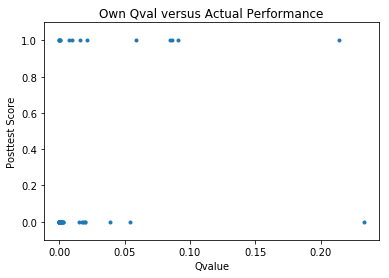

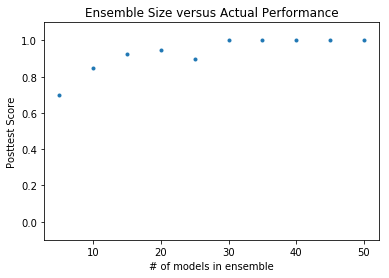

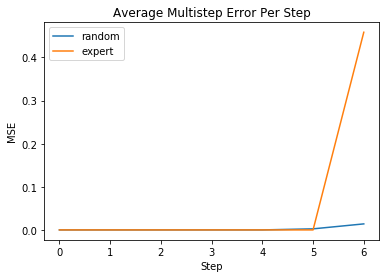

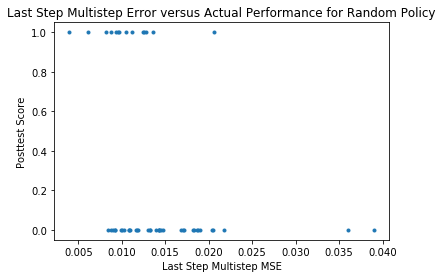

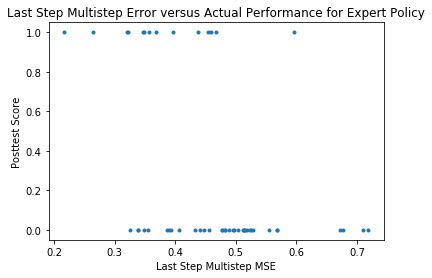

In [18]:
data11 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runB.npz')

with open('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearch-runB-horizon6.pickle','rb') as f:
    fsdata = pickle.load(f)

with open('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/fsearchensemble-runB-horizon6-n40.pickle','rb') as f:
    fsensemble = pickle.load(f)

with open('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/multistep-runB-horizon6-n10000.pickle','rb') as f:
    multistep = pickle.load(f)

fs_sq = np.array([d[0][1] for d in fsdata])
fs_sim_sq = np.array([d[0][3] for d in fsdata])
six.print_(fs_sim_sq)

fsen_sq, fsen_sim_sq = extract_ensemble_data(fsensemble)
six.print_(fsen_sim_sq)
six.print_(fsen_sq)

vloss = np.vstack((data11['vloss'],))
vloss_auc = np.sum(vloss,axis=1)
vloss_last = np.mean(vloss[:,-2:],axis=1)

tloss = np.vstack((data11['tloss'],))
tloss_auc = np.sum(tloss,axis=1)
tloss_last = np.mean(tloss[:,-2:],axis=1)

sorted_by_fs_sim_sq = np.flipud(np.argsort(fs_sim_sq))
ranked_by_fs_sim_sq = ixs2ranks(sorted_by_fs_sim_sq)

sorted_by_fs_sq = np.flipud(np.argsort(fs_sq))
ranked_by_fs_sq = ixs2ranks(sorted_by_fs_sq)

sorted_by_vloss = np.argsort(vloss_auc)
ranked_by_vloss = ixs2ranks(sorted_by_vloss)

six.print_('vloss shape {}'.format(vloss.shape))

num_models = vloss_auc.shape[0]

#graph_trainauc_score(vloss, fs_sim_sq)
#ylim(-0.1,1.1)
# 14/50 good policy-models


graph_qval_score(fs_sq, fs_sim_sq)
ylim(-0.1,1.1)

graph_ensemble(fsen_sq, fsen_sim_sq)

# multistep stuff
ms_random, ms_expert = extract_last_step_error(multistep)
graph_average_ms(multistep)

graph_ms_score(ms_random, fs_sim_sq, 'Random')
graph_ms_score(ms_expert, fs_sim_sq, 'Expert')